The code has been tested with Python 3.11.13

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from segmentation.segmenters import Segmenter, WaveletDecompositionModel, F1Loss, MangoOptimizer
from uschad import UscHadUser
import argparse

/opt/homebrew/Caskroom/miniforge/base/envs/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Settings for USC-HAD Dataset

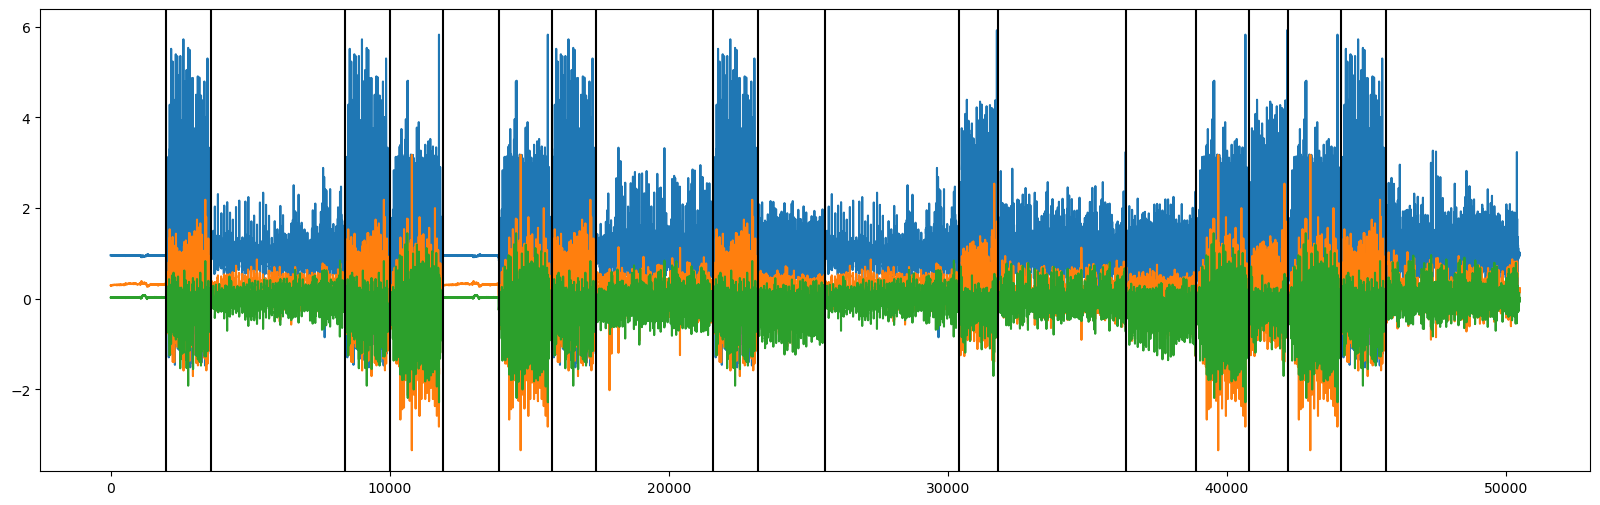

In [2]:
DATASET = 'uschad'

parser = argparse.ArgumentParser()
# Checkpoint directory
parser.add_argument('--root_folder', type=str, default=f'data/{DATASET}/', help='Root folder for dataset')
parser.add_argument('--dataset', type=str, default=f'{DATASET}', help='The name of the dataset to use.')
parser.add_argument('--ws', type=int, default=100, help='Window size.')
parser.add_argument('--peak_tolerance', type=int, default=100, help='Peak tolerance for active learning.')
parser.add_argument('--level_wavelet', type=str, default=6, help='Level of the wavelet decomposition.')
parser.add_argument('--opt_max_calls', type=str, default=50, help='Optimizer max number of calls.')
parser.add_argument('--n_query', type=str, default=50, help='Maximum number of query for active learning.')

args = parser.parse_args("")

USR_IDX = 2

user = UscHadUser('data/USC-HAD', usr_idx=USR_IDX)

samples, gt_break_points = user.get_random_stream(n_trial=1, n_activity=20)

plt.figure(figsize=(20, 6))
plt.plot(samples)
for bkp in gt_break_points:
    plt.axvline(bkp, color='k')

# Settings for BabyECG Dataset

In [3]:
# DATASET = 'babyecg'

# parser = argparse.ArgumentParser()
# # Checkpoint directory
# parser.add_argument('--root_folder', type=str, default=f'data/{DATASET}/', help='Root folder for dataset')
# parser.add_argument('--dataset', type=str, default=f'{DATASET}', help='The name of the dataset to use.')
# parser.add_argument('--ws', type=int, default=15, help='Window size.')
# parser.add_argument('--peak_tolerance', type=int, default=15, help='Peak tolerance for active learning.')
# parser.add_argument('--level_wavelet', type=str, default=3, help='Level of the wavelet decomposition.')
# parser.add_argument('--opt_max_calls', type=str, default=50, help='Optimizer max number of calls.')
# parser.add_argument('--n_query', type=str, default=92, help='Maximum number of query for active learning.')

# args = parser.parse_args("")

# dataset = np.load(f'{args.root_folder}babyecg_dataset.npz')

# samples = dataset['original_samples']
# gt_break_points = dataset['bkps']

# plt.figure(figsize=(20, 6))
# plt.plot(samples)
# for bkp in gt_break_points:
#     plt.axvline(bkp, color='k')

# Settings for UCI-HAR Dataset

In [4]:
# DATASET = 'ucihar'

# parser = argparse.ArgumentParser()
# # Checkpoint directory
# parser.add_argument('--root_folder', type=str, default=f'data/{DATASET}/', help='Root folder for dataset')
# parser.add_argument('--dataset', type=str, default=f'{DATASET}', help='The name of the dataset to use.')
# parser.add_argument('--ws', type=int, default=12, help='Window size.')
# parser.add_argument('--peak_tolerance', type=int, default=8, help='Peak tolerance for active learning.')
# parser.add_argument('--level_wavelet', type=str, default=2, help='Level of the wavelet decomposition.')
# parser.add_argument('--opt_max_calls', type=str, default=50, help='Optimizer max number of calls.')
# parser.add_argument('--n_query', type=str, default=100, help='Maximum number of query for active learning.')

# args = parser.parse_args("")

# samples = np.load(f'{args.root_folder}sequence1.npy')[:,:50]
# gt_break_points = np.load(f'{args.root_folder}labels1.npy')

# plt.figure(figsize=(20, 6))
# plt.plot(samples)
# for bkp in gt_break_points:
#     plt.axvline(bkp, color='k')

# Settings for Honeybee Dance Dataset

In [5]:
# DATASET = 'honeybee'

# parser = argparse.ArgumentParser()
# # Checkpoint directory
# parser.add_argument('--root_folder', type=str, default=f'data/{DATASET}/', help='Root folder for dataset')
# parser.add_argument('--dataset', type=str, default=f'{DATASET}', help='The name of the dataset to use.')
# parser.add_argument('--ws', type=int, default=30, help='Window size.')
# parser.add_argument('--peak_tolerance', type=int, default=15, help='Peak tolerance for active learning.')
# parser.add_argument('--level_wavelet', type=str, default=5, help='Level of the wavelet decomposition.')
# parser.add_argument('--opt_max_calls', type=str, default=50, help='Optimizer max number of calls.')
# parser.add_argument('--n_query', type=str, default=30, help='Maximum number of query for active learning.')

# args = parser.parse_args("")

# samples = np.load(f'{args.root_folder}sequence1.npy')
# gt_break_points = np.load(f'{args.root_folder}labels1.npy')

# plt.figure(figsize=(20, 6))
# plt.plot(samples)
# for bkp in gt_break_points:
#     plt.axvline(bkp, color='k')

# Run MuRAL-CPD

In [3]:
mu = samples.mean()
sigma = samples.std()
samples = (samples - mu)/(3*sigma) 

score_model = WaveletDecompositionModel(samples, windows_size=args.ws, level_wavelet=args.level_wavelet)
segmenter = Segmenter(score_model=score_model)
optimizer = MangoOptimizer(max_calls=args.opt_max_calls, regularization=1e-2)
loss = F1Loss(peak_tolerance=args.peak_tolerance, threshold=segmenter.threshold)
segmenter.compile(loss, optimizer)

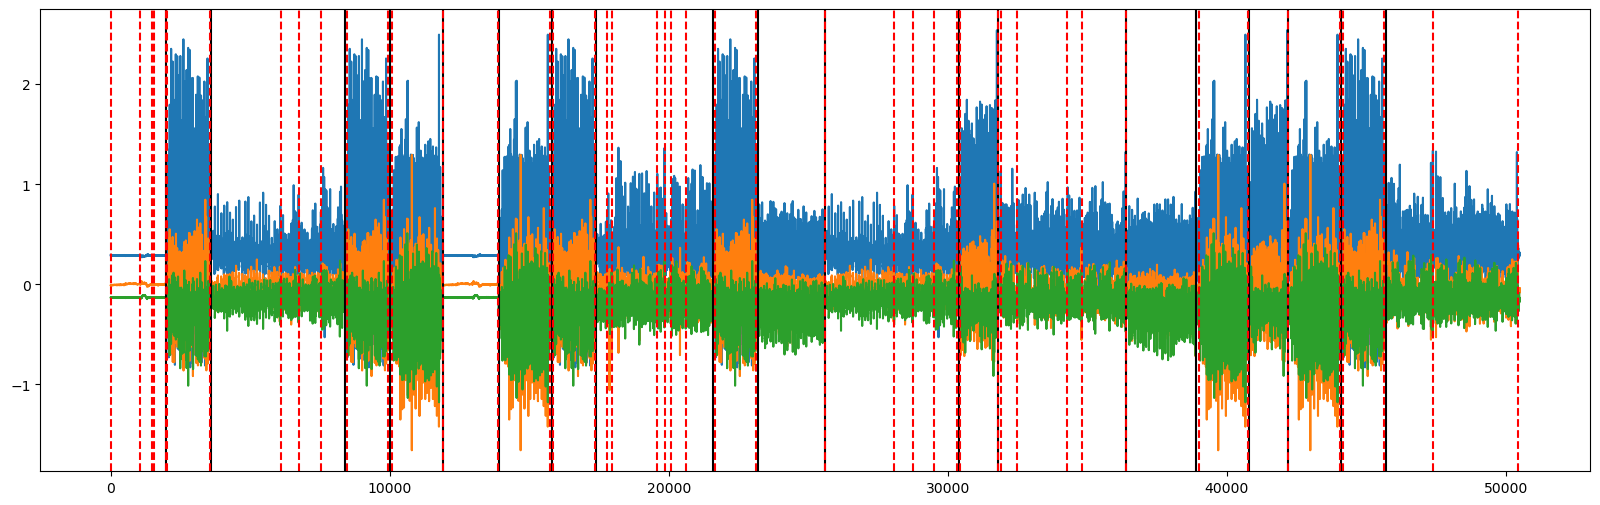

In [4]:
break_points = segmenter.get_break_points()

plt.figure(figsize=(20, 6))
plt.plot(samples)
for bkp in gt_break_points:
    plt.axvline(bkp, color='black')
for bkp in break_points:
    plt.axvline(bkp, color='red', linestyle = '--')

In [5]:

precision, recall, f1 = segmenter.get_metrics(break_points=break_points, gt_break_points=gt_break_points)
print(f'  --/-- Metrics unsupervised model:     Precision = {precision},  Recall = {recall},  F1 = {f1} --/--')

for q in range(args.n_query//2):
    unsupervised_score = segmenter.get_unsupervised_score()

    indices = segmenter.get_least_certain()
    for index in indices: 
        start_idx = max(0, index - args.peak_tolerance)
        end_idx = min(len(samples), index + args.peak_tolerance)

        flag = False
        for gt in gt_break_points:
            if start_idx <= gt <= end_idx:
                segmenter.add_break_point_to_gt(gt, supervised_interval=[start_idx, end_idx])
                flag = True
                break
        # else...
        if not flag:
            segmenter.supervised_domain.add_interval([start_idx, end_idx])

    if q > 5:        
        segmenter.update()

    # get the new break points
    break_points = segmenter.get_break_points()
    precision, recall, f1 = segmenter.get_metrics(break_points=break_points, gt_break_points=gt_break_points)
    print(f'  --/-- Metrics after {2*q} query:     Precision = {precision},  Recall = {recall},  F1 = {f1} --/--\n')
    print(f'               ###############                  \n')

precision, recall, f1 = segmenter.get_metrics(break_points=break_points, gt_break_points=gt_break_points)
print(f'  --/-- Metrics after active loop:     Precision = {precision},  Recall = {recall},  F1 = {f1} --/--')

  --/-- Metrics unsupervised model:     Precision = 0.41304347826086957,  Recall = 1.0,  F1 = 0.5846153846153846 --/--
  --/-- Metrics after 0 query:     Precision = 0.4222222222222222,  Recall = 1.0,  F1 = 0.59375 --/--

               ###############                  

  --/-- Metrics after 2 query:     Precision = 0.4318181818181818,  Recall = 1.0,  F1 = 0.6031746031746031 --/--

               ###############                  

  --/-- Metrics after 4 query:     Precision = 0.4318181818181818,  Recall = 1.0,  F1 = 0.6031746031746031 --/--

               ###############                  

  --/-- Metrics after 6 query:     Precision = 0.4418604651162791,  Recall = 1.0,  F1 = 0.6129032258064516 --/--

               ###############                  

  --/-- Metrics after 8 query:     Precision = 0.4523809523809524,  Recall = 1.0,  F1 = 0.6229508196721312 --/--

               ###############                  

  --/-- Metrics after 10 query:     Precision = 0.4634146341463415,  Rec

Best loss: 2.8679276992683547: 100%|██████████| 50/50 [00:01<00:00, 37.53it/s]


  --/-- Metrics after 12 query:     Precision = 1.0,  Recall = 0.21052631578947367,  F1 = 0.34782608695652173 --/--

               ###############                  



Best loss: 2.8679276992683547: 100%|██████████| 50/50 [00:01<00:00, 38.25it/s]


  --/-- Metrics after 14 query:     Precision = 1.0,  Recall = 0.2631578947368421,  F1 = 0.4166666666666667 --/--

               ###############                  



Best loss: 2.8679276992683547: 100%|██████████| 50/50 [00:01<00:00, 38.31it/s]


  --/-- Metrics after 16 query:     Precision = 1.0,  Recall = 0.3157894736842105,  F1 = 0.4799999999999999 --/--

               ###############                  



Best loss: 2.918478583791863: 100%|██████████| 50/50 [00:01<00:00, 38.71it/s]


  --/-- Metrics after 18 query:     Precision = 0.475,  Recall = 1.0,  F1 = 0.6440677966101694 --/--

               ###############                  



Best loss: 2.9500991371515473: 100%|██████████| 50/50 [00:01<00:00, 37.21it/s]


  --/-- Metrics after 20 query:     Precision = 0.48717948717948717,  Recall = 1.0,  F1 = 0.6551724137931034 --/--

               ###############                  



Best loss: 2.192976479721903: 100%|██████████| 50/50 [00:01<00:00, 39.65it/s]


  --/-- Metrics after 22 query:     Precision = 1.0,  Recall = 0.42105263157894735,  F1 = 0.5925925925925926 --/--

               ###############                  



Best loss: 2.2768925636379866: 100%|██████████| 50/50 [00:01<00:00, 38.34it/s]


  --/-- Metrics after 24 query:     Precision = 1.0,  Recall = 0.5263157894736842,  F1 = 0.6896551724137931 --/--

               ###############                  



Best loss: 2.3098595966050195: 100%|██████████| 50/50 [00:01<00:00, 38.76it/s]


  --/-- Metrics after 26 query:     Precision = 1.0,  Recall = 0.5789473684210527,  F1 = 0.7333333333333334 --/--

               ###############                  



Best loss: 2.363431025176448: 100%|██████████| 50/50 [00:01<00:00, 37.34it/s]


  --/-- Metrics after 28 query:     Precision = 1.0,  Recall = 0.6842105263157895,  F1 = 0.8125000000000001 --/--

               ###############                  



Best loss: 2.405097691843115: 100%|██████████| 50/50 [00:01<00:00, 36.53it/s]


  --/-- Metrics after 30 query:     Precision = 1.0,  Recall = 0.7894736842105263,  F1 = 0.8823529411764706 --/--

               ###############                  



Best loss: 2.438431025176448: 100%|██████████| 50/50 [00:01<00:00, 38.82it/s]


  --/-- Metrics after 32 query:     Precision = 1.0,  Recall = 0.8947368421052632,  F1 = 0.9444444444444444 --/--

               ###############                  



Best loss: 2.4657037524491754: 100%|██████████| 50/50 [00:01<00:00, 38.51it/s]


  --/-- Metrics after 34 query:     Precision = 1.0,  Recall = 1.0,  F1 = 1.0 --/--

               ###############                  



Best loss: 2.488431025176448: 100%|██████████| 50/50 [00:01<00:00, 37.12it/s]


  --/-- Metrics after 36 query:     Precision = 1.0,  Recall = 1.0,  F1 = 1.0 --/--

               ###############                  



Best loss: 2.488431025176448: 100%|██████████| 50/50 [00:01<00:00, 36.30it/s]


  --/-- Metrics after 38 query:     Precision = 1.0,  Recall = 1.0,  F1 = 1.0 --/--

               ###############                  



Best loss: 2.488431025176448: 100%|██████████| 50/50 [00:01<00:00, 36.58it/s]


  --/-- Metrics after 40 query:     Precision = 1.0,  Recall = 1.0,  F1 = 1.0 --/--

               ###############                  



Best loss: 2.488431025176448: 100%|██████████| 50/50 [00:01<00:00, 36.32it/s]


  --/-- Metrics after 42 query:     Precision = 1.0,  Recall = 1.0,  F1 = 1.0 --/--

               ###############                  



Best loss: 2.488431025176448: 100%|██████████| 50/50 [00:01<00:00, 38.19it/s]


  --/-- Metrics after 44 query:     Precision = 1.0,  Recall = 1.0,  F1 = 1.0 --/--

               ###############                  



Best loss: 2.488431025176448: 100%|██████████| 50/50 [00:01<00:00, 36.82it/s]


  --/-- Metrics after 46 query:     Precision = 1.0,  Recall = 1.0,  F1 = 1.0 --/--

               ###############                  



Best loss: 2.488431025176448: 100%|██████████| 50/50 [00:01<00:00, 36.43it/s]

  --/-- Metrics after 48 query:     Precision = 1.0,  Recall = 1.0,  F1 = 1.0 --/--

               ###############                  

  --/-- Metrics after active loop:     Precision = 1.0,  Recall = 1.0,  F1 = 1.0 --/--


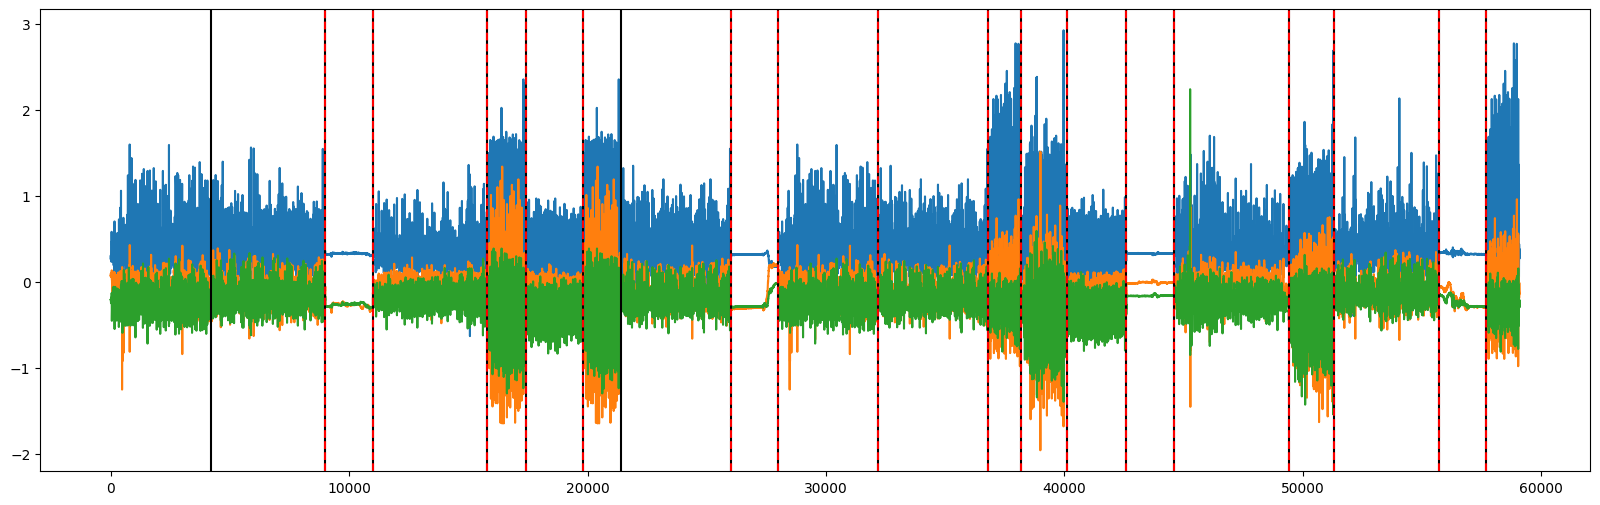

In [9]:
break_points = segmenter.get_break_points()
plt.figure(figsize=(20, 6))
plt.plot(samples)
for gt in gt_break_points:
    plt.axvline(gt, color='black')
for bkps in break_points:
    plt.axvline(bkps, color='red', linestyle='--')